In [3]:
# import libraries 
import fitz 
import io 
from PIL import Image 
import os
import json
import matplotlib.pyplot as plt

#PyMuPDF 
pwd = os.getcwd()
# file path you want to extract images from 
source = os.path.join(pwd,'source_files')
file = os.path.join(source,'paper.pdf')


def load_pdf(source_files, file_):
 # open the file 
 pdf_file = fitz.open(file_) 
 image_counter = 0
 metadata = {}
 for page_index in range(0,len(pdf_file)): 
  # get the page itself 
  page = pdf_file[page_index] 
  # get block details from the page
  blocks = pdf_file[page_index].get_text("blocks")
  # get image info and title details 
  image_meta = [ (blocks[i][4], blocks[i+1][4]) for i in range(0,len(blocks)) if blocks[i][-1]==1 ]  
  image_info= [ image_meta[0][0] if image_meta  else []] 
  image_title = [ image_meta[0][1] if image_meta else []] 
  # prepare image meta data from the page
  for image in page.get_images():
   image_id = image[7] # img<no>
   image_block_id = image[0] # block number 
   image_title_block_id = image_block_id+1 # image title block number
   image_dim = image[2],image[3] # image dimension details
   
   print(f"[+] Page:{page_index}, Image : {image_id}, Block:{image_block_id}, Image Dim:{image_dim}")
   image_counter = image_counter+1

   # Update metadata dictionary with image information
   metadata[image_counter] = {
    'page': page_index,
    'image': image_id,
    'block': image_block_id,
    'image_dim': image_dim,
    'image_info': str(image_info[0]),
    'image_title': str(image_title[0]),
    'image_file': f"{image_id}_{image_block_id}.png",
    'image_path': os.path.join(source_files, f"{image_id}_{image_block_id}.png")
   }
  # save the images to the local file system
   pix = fitz.Pixmap(pdf_file, image[0])
   # image file name contains image name 'img<no>' and block number
   pix.save(os.path.join(source_files, f"{image_id}_{image_block_id}.png"))
 print(f"Total Images: {image_counter}")
 
 with open(os.path.join(source,f'metadata.json'),'w') as f:
  json.dump(metadata,f)
 return metadata
 
metadata = load_pdf(source, file)

Matplotlib is building the font cache; this may take a moment.


[+] Page:0, Image : Im1, Block:61, Image Dim:(446, 446)
[+] Page:0, Image : Im10, Block:70, Image Dim:(512, 512)
[+] Page:0, Image : Im11, Block:71, Image Dim:(655, 490)
[+] Page:0, Image : Im12, Block:72, Image Dim:(652, 758)
[+] Page:0, Image : Im13, Block:73, Image Dim:(443, 443)
[+] Page:0, Image : Im14, Block:74, Image Dim:(409, 409)
[+] Page:0, Image : Im2, Block:62, Image Dim:(413, 412)
[+] Page:0, Image : Im3, Block:63, Image Dim:(303, 300)
[+] Page:0, Image : Im4, Block:64, Image Dim:(163, 163)
[+] Page:0, Image : Im5, Block:65, Image Dim:(370, 370)
[+] Page:0, Image : Im6, Block:66, Image Dim:(336, 336)
[+] Page:0, Image : Im7, Block:67, Image Dim:(416, 416)
[+] Page:0, Image : Im8, Block:68, Image Dim:(383, 383)
[+] Page:0, Image : Im9, Block:69, Image Dim:(650, 483)
[+] Page:2, Image : Im1, Block:169, Image Dim:(626, 706)
[+] Page:2, Image : Im10, Block:178, Image Dim:(82, 81)
[+] Page:2, Image : Im11, Block:179, Image Dim:(92, 92)
[+] Page:2, Image : Im12, Block:180, Image

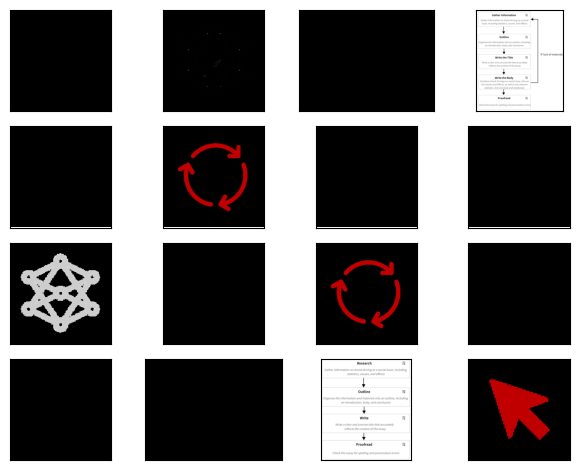

In [4]:
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

def plot_images_metadata(metadata):
    # List to store original image URLs
    original_images_urls = []
    # Counter to track the number of images shown
    images_shown = 0

    # Iterate through each image in the metadata
    for image_id in metadata:
        # Get the image path from metadata
        image_path = metadata[image_id]['image_path']
        # Check if the file exists
        if os.path.isfile(image_path):
            # Get filename from metadata
            filename = metadata[image_id]['image_file']
            # Open and convert the image to RGB
            image = Image.open(image_path).convert("RGB")

            # Plot the image in a subplot
            plt.subplot(4, 4, len(original_images_urls) + 1)
            plt.imshow(image)
           
            # Remove ticks for clarity
            plt.xticks([])
            plt.yticks([])

            # Add filename to the list of original image URLs
            original_images_urls.append(filename)
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 16 images have been shown
            if images_shown >= 16:
                break

    # Adjust layout for better visualization
    plt.tight_layout()

# Call the function with the provided metadata
plot_images_metadata(metadata)

In [10]:
import qdrant_client
from llama_index.core import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices  import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm")

# Create QdrantVectorStore instances for text and image collections
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

# Create a StorageContext to hold vector and image stores
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Load data from a SimpleDirectoryReader for creating the MultiModal index
documents = SimpleDirectoryReader("./source_files/").load_data()

# Create a MultiModalVectorStoreIndex from the loaded documents
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

ModuleNotFoundError: No module named 'llama_index.indices.multi_modal'